In [27]:
import csv
import multiprocessing
import os
import random
import shutil
import time
import math

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns


In [14]:
from solver.simulated_annealing import SimulatedAnnealing, run_simulated_annealing
from solver.max_weighted_cnf import MaxWeightedCNF
from solver.optimum import Optimum

In [3]:
DATA_SUITES = (
    'wuf20-71',
    'wuf20-71R',
    'wuf20-91',
    'wuf20-91R',
    'wuf50-200',
    'wuf50-218',
    'wuf50-218R',
    'wuf75-325',
    'wuf100-430',
)

DATA_SUITES_VARIATIONS = (
    'M',
    'N',
    'Q',
    'R',
)

In [4]:
DATA_DIRECTORY = 'data'
OUTPUT_DIRECTORY = 'output'
BACKUP_DIRECTORY = 'backup'

In [13]:
def flatten(list):
    return [item for sublist in list for item in sublist]

In [5]:
# RUNS = 1
#
# def flatten(list):
#     return [item for sublist in list for item in sublist]
#
# if not os.path.exists(BACKUP_DIRECTORY):
#     os.mkdir(BACKUP_DIRECTORY)
# BACKUP_TIMESTAMP = time.time().__str__()
#
# if os.path.exists(OUTPUT_DIRECTORY):
#     shutil.copytree(OUTPUT_DIRECTORY, os.path.join(BACKUP_DIRECTORY, BACKUP_TIMESTAMP))
#     shutil.rmtree(OUTPUT_DIRECTORY)
# os.mkdir(OUTPUT_DIRECTORY)
#
# for suite in DATA_SUITES:
#     os.mkdir(os.path.join(OUTPUT_DIRECTORY, suite))
#
#     for suite_variation in DATA_SUITES_VARIATIONS:
#         print(suite, suite_variation)
#
#         os.mkdir(os.path.join(OUTPUT_DIRECTORY, suite, suite_variation))
#         sa_output = open(os.path.join(OUTPUT_DIRECTORY, suite, suite_variation, 'sa.csv'), 'w')
#
#         sa_heading = ['instance', 'weight', 'satisfied_clauses', 'clauses',
#                       'true_variables', 'variables', 'current_objective_history', 'best_objective_history']
#         sa_writer = csv.writer(sa_output)
#
#         sa_writer.writerow(sa_heading)
#
#         optimum = None
#         optimum_path = os.path.join(DATA_DIRECTORY, suite, f'{suite}-{suite_variation}-opt.dat')
#
#         if os.path.exists(optimum_path):
#             optimum = Optimum(optimum_path)
#
#         for root, _, files in os.walk(os.path.join(DATA_DIRECTORY, suite, f'{suite}-{suite_variation}')):
#             sas = flatten([
#                 [
#                     SimulatedAnnealing(
#                         MaxWeightedCNF(os.path.join(root, file))
#                     )
#                 ] * RUNS for file in files
#             ])
#
#             pool = multiprocessing.Pool(processes=8)
#
#             sa_results = list(tqdm(pool.imap(run_simulated_annealing, sas), total=len(sas)))
#
#             sa_results = [(result[0].split('/')[-1],
#                            result[1], result[2], result[3], result[4],
#                            result[5], result[6], result[7]) for result in sa_results]
#
#             sa_results.sort(key=lambda result: result[0])
#
#             sa_writer.writerows(sa_results)

In [6]:
def run_simulation(suite, suite_variation, instance, initial_temperature):
    _, weight, satisfied_clauses, clauses, true_variables, variables, current_objective_history, best_objective_history = SimulatedAnnealing(
        MaxWeightedCNF(os.path.join(DATA_DIRECTORY, suite, f'{suite}-{suite_variation}', instance)),
        initial_temperature=initial_temperature
    ).run(record_history=True)

    optimum_path = os.path.join(DATA_DIRECTORY, suite, f'{suite}-{suite_variation}-opt.dat')
    optimum = Optimum(optimum_path)

    optimal_weight = optimum.optimal_weight(instance[1:].rstrip('.mwcnf'))

    return optimal_weight, weight, satisfied_clauses, clauses, true_variables, variables, current_objective_history, best_objective_history

In [7]:
def run_experiment_initial_temperature(suite, suite_variation, instance, initial_temperatures=(5000, 2500, 1000, 500)):
    fig, axes = plt.subplots(math.ceil(len(initial_temperatures) / 2), 2, figsize=(20, 20))

    if len(initial_temperatures) % 2 != 0:
        for l in axes[int(len(initial_temperatures) / 2 - 1), 1].get_xaxis().get_majorticklabels():
            l.set_visible(True)
        fig.delaxes(axes[int(len(initial_temperatures) / 2), 1])

    for i, initial_temperature in enumerate(initial_temperatures):
        optimal_weight, weight, satisfied_clauses, clauses, true_variables, variables, current_objective_history, best_objective_history = run_simulation(
            suite, suite_variation, instance, initial_temperature
        )
        optimal_weight_history = [optimal_weight] * len(current_objective_history)

        ax = axes[int(i / 2), i % 2]

        sns.lineplot(data=current_objective_history, label='Current', ax=ax)
        sns.lineplot(data=best_objective_history, label='Best', ax=ax)
        sns.lineplot(data=optimal_weight_history, label='Optimal', ax=ax)

        ax.set_title(
            f'initial temperature: {initial_temperature}\nsatisfied clauses {satisfied_clauses}/{clauses}\ntrue variables: {true_variables}/{variables}\nweight: {weight}/{optimal_weight} ({round(100 * (weight / optimal_weight))}%)')
        ax.set_xlabel('Steps')
        ax.set_ylabel('Weight')
        ax.legend()

    fig.suptitle(f'Initial temperature experiment\n{suite}-{suite_variation}/{instance}', fontsize=30)
    #fig.tight_layout(pad=5, rect=[0, 0.03, 1, 0.95])

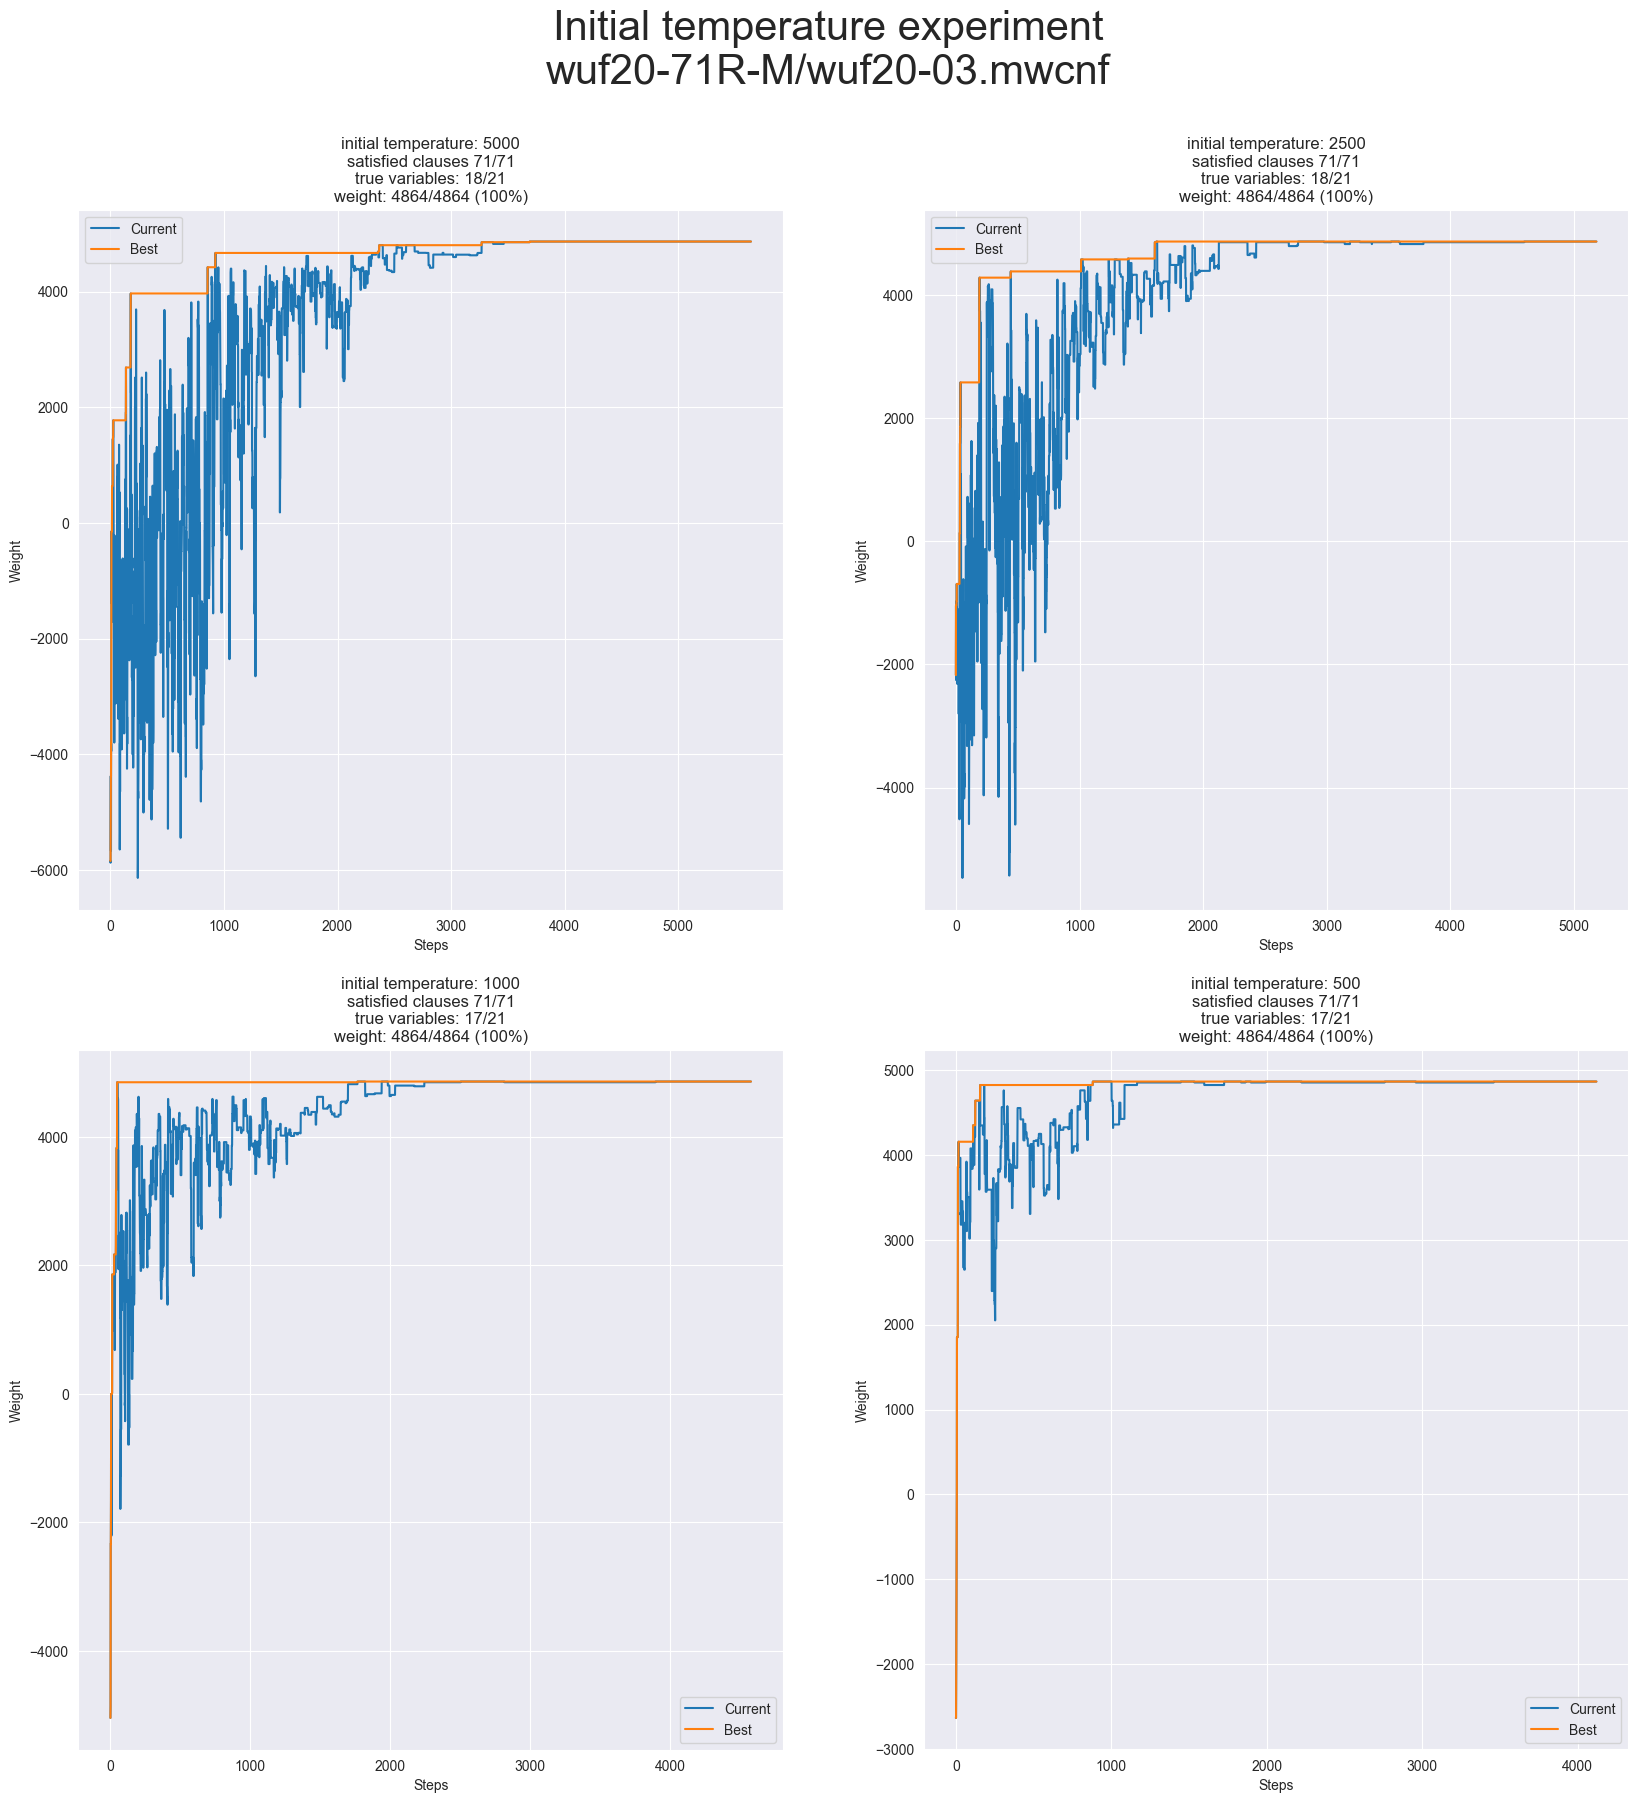

In [8]:
suite = 'wuf20-71R'
suite_variation = 'M'
instance = 'wuf20-03.mwcnf'

run_experiment_initial_temperature(suite, suite_variation, instance)

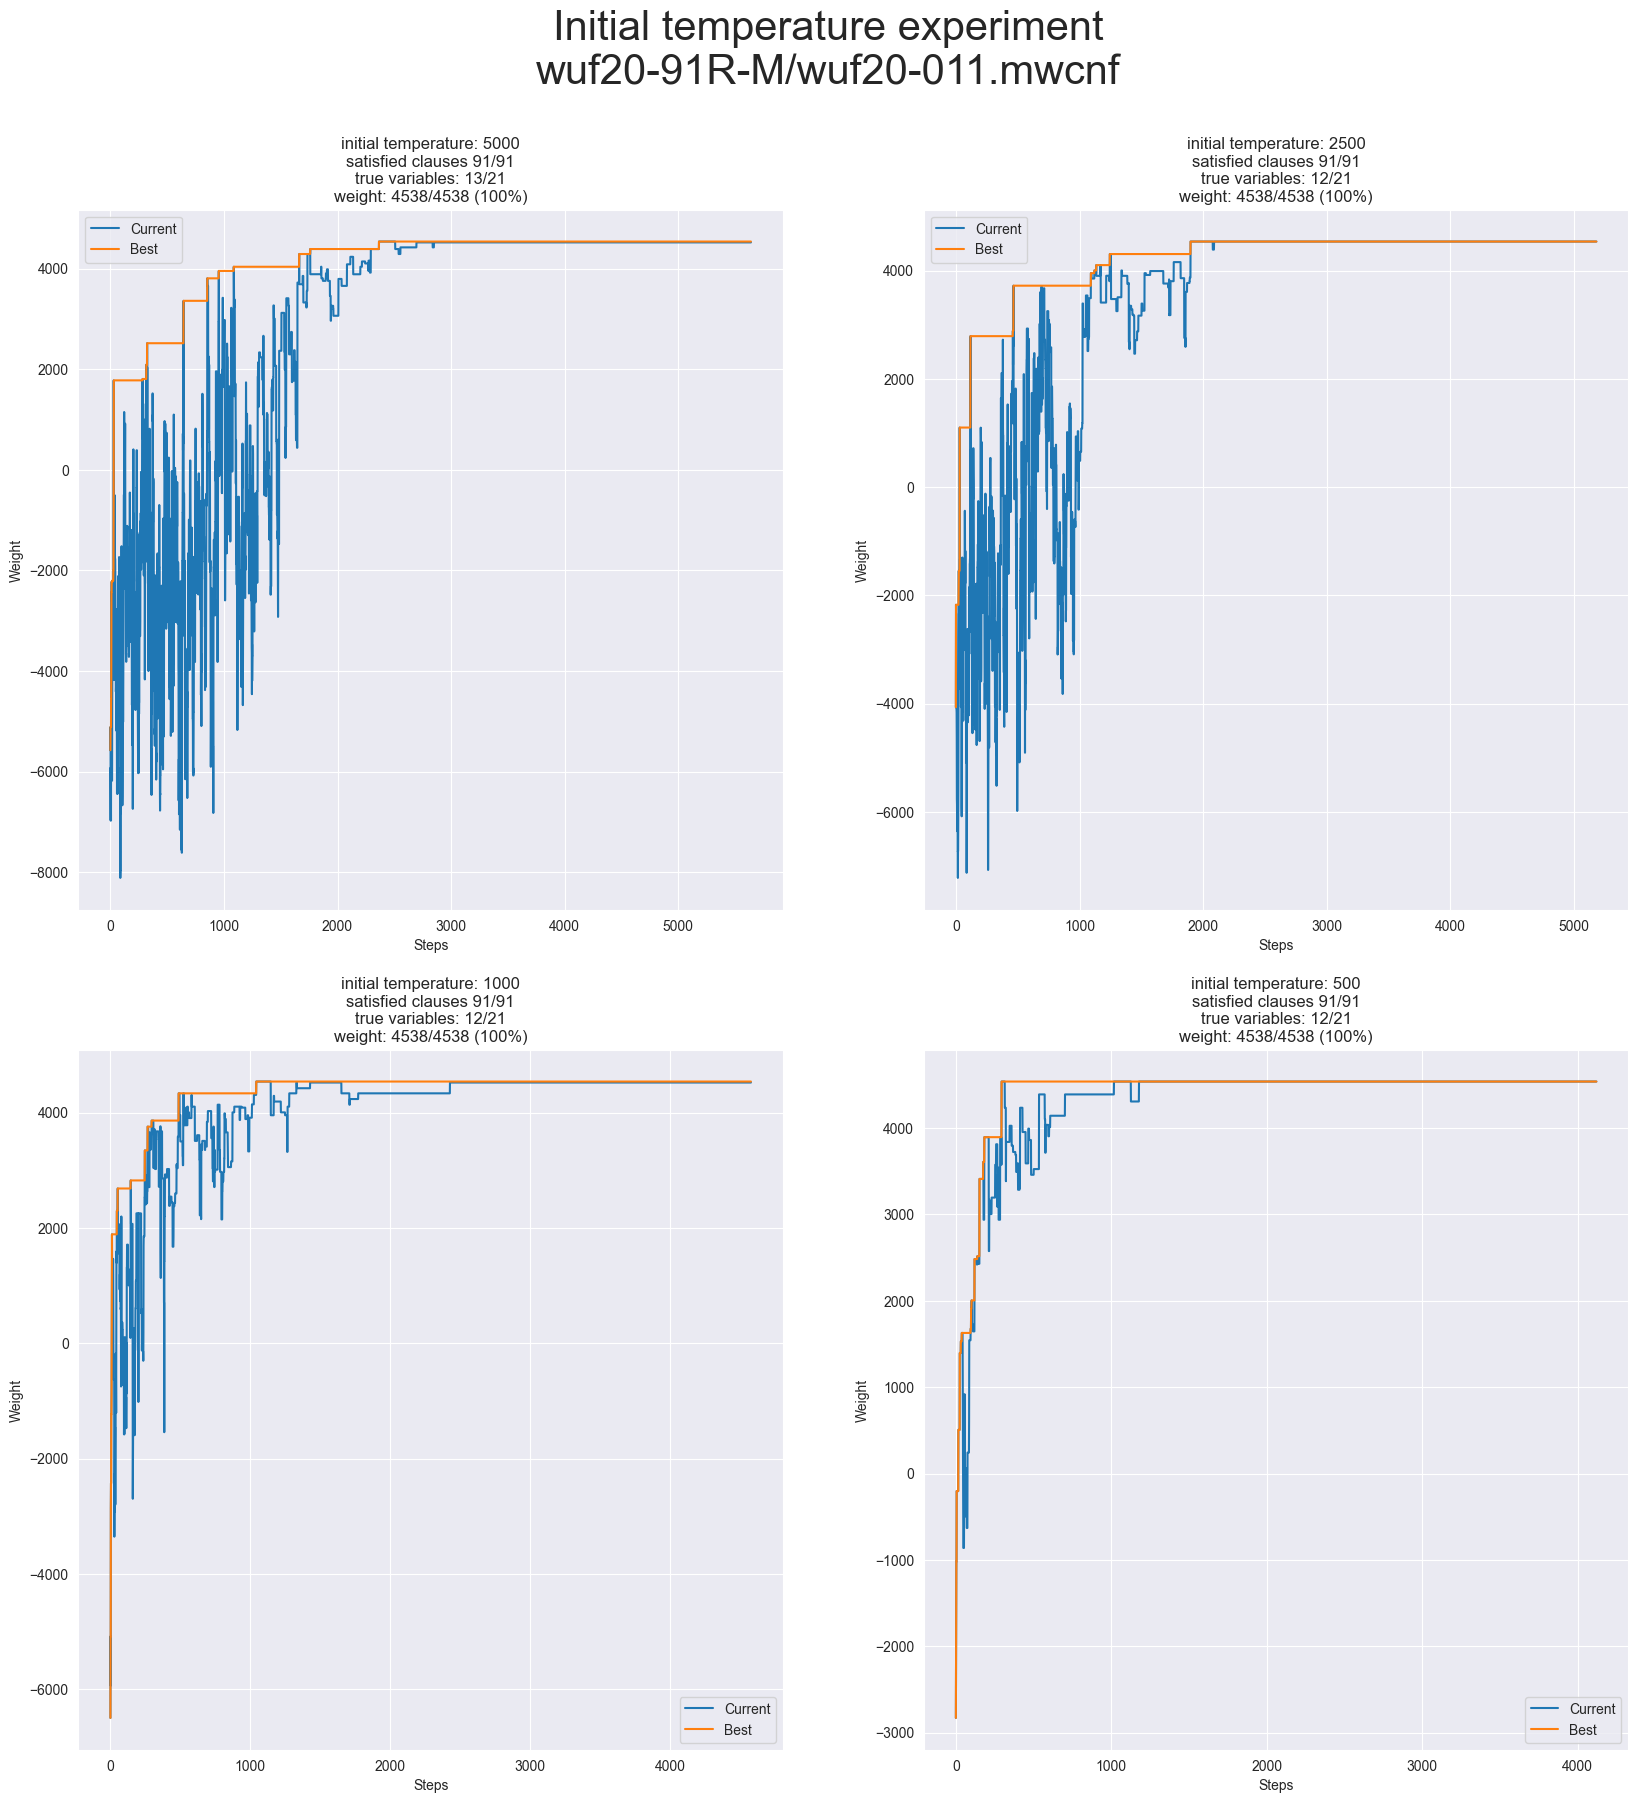

In [9]:
suite = 'wuf20-91R'
suite_variation = 'M'
instance = 'wuf20-011.mwcnf'

run_experiment_initial_temperature(suite, suite_variation, instance)

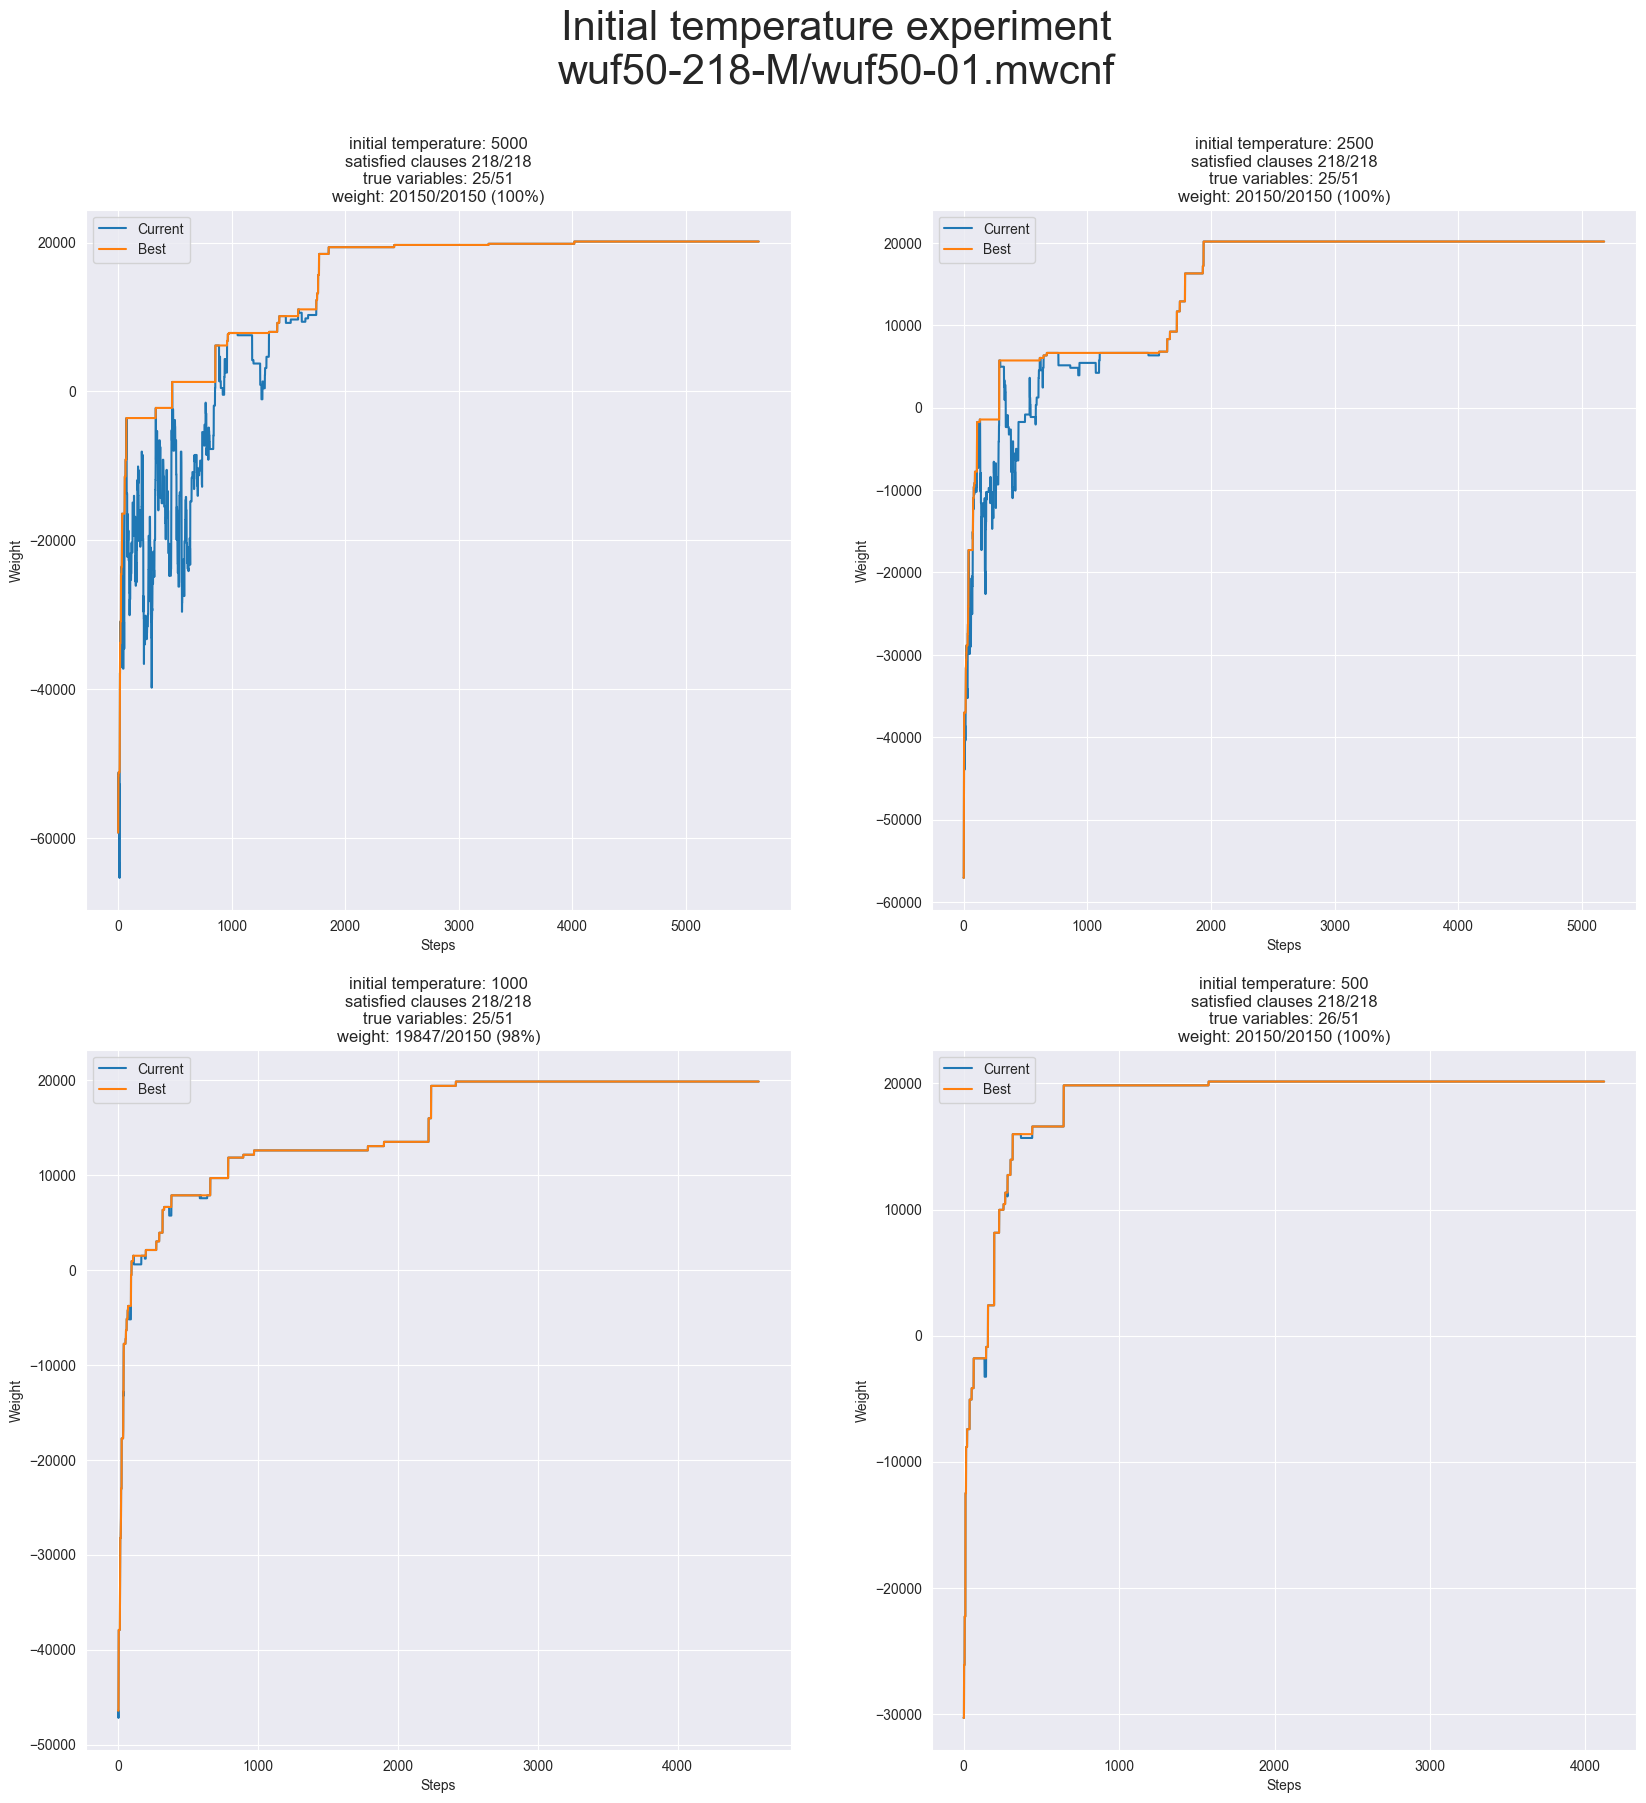

In [10]:
suite = 'wuf50-218'
suite_variation = 'M'
instance = 'wuf50-01.mwcnf'

run_experiment_initial_temperature(suite, suite_variation, instance)

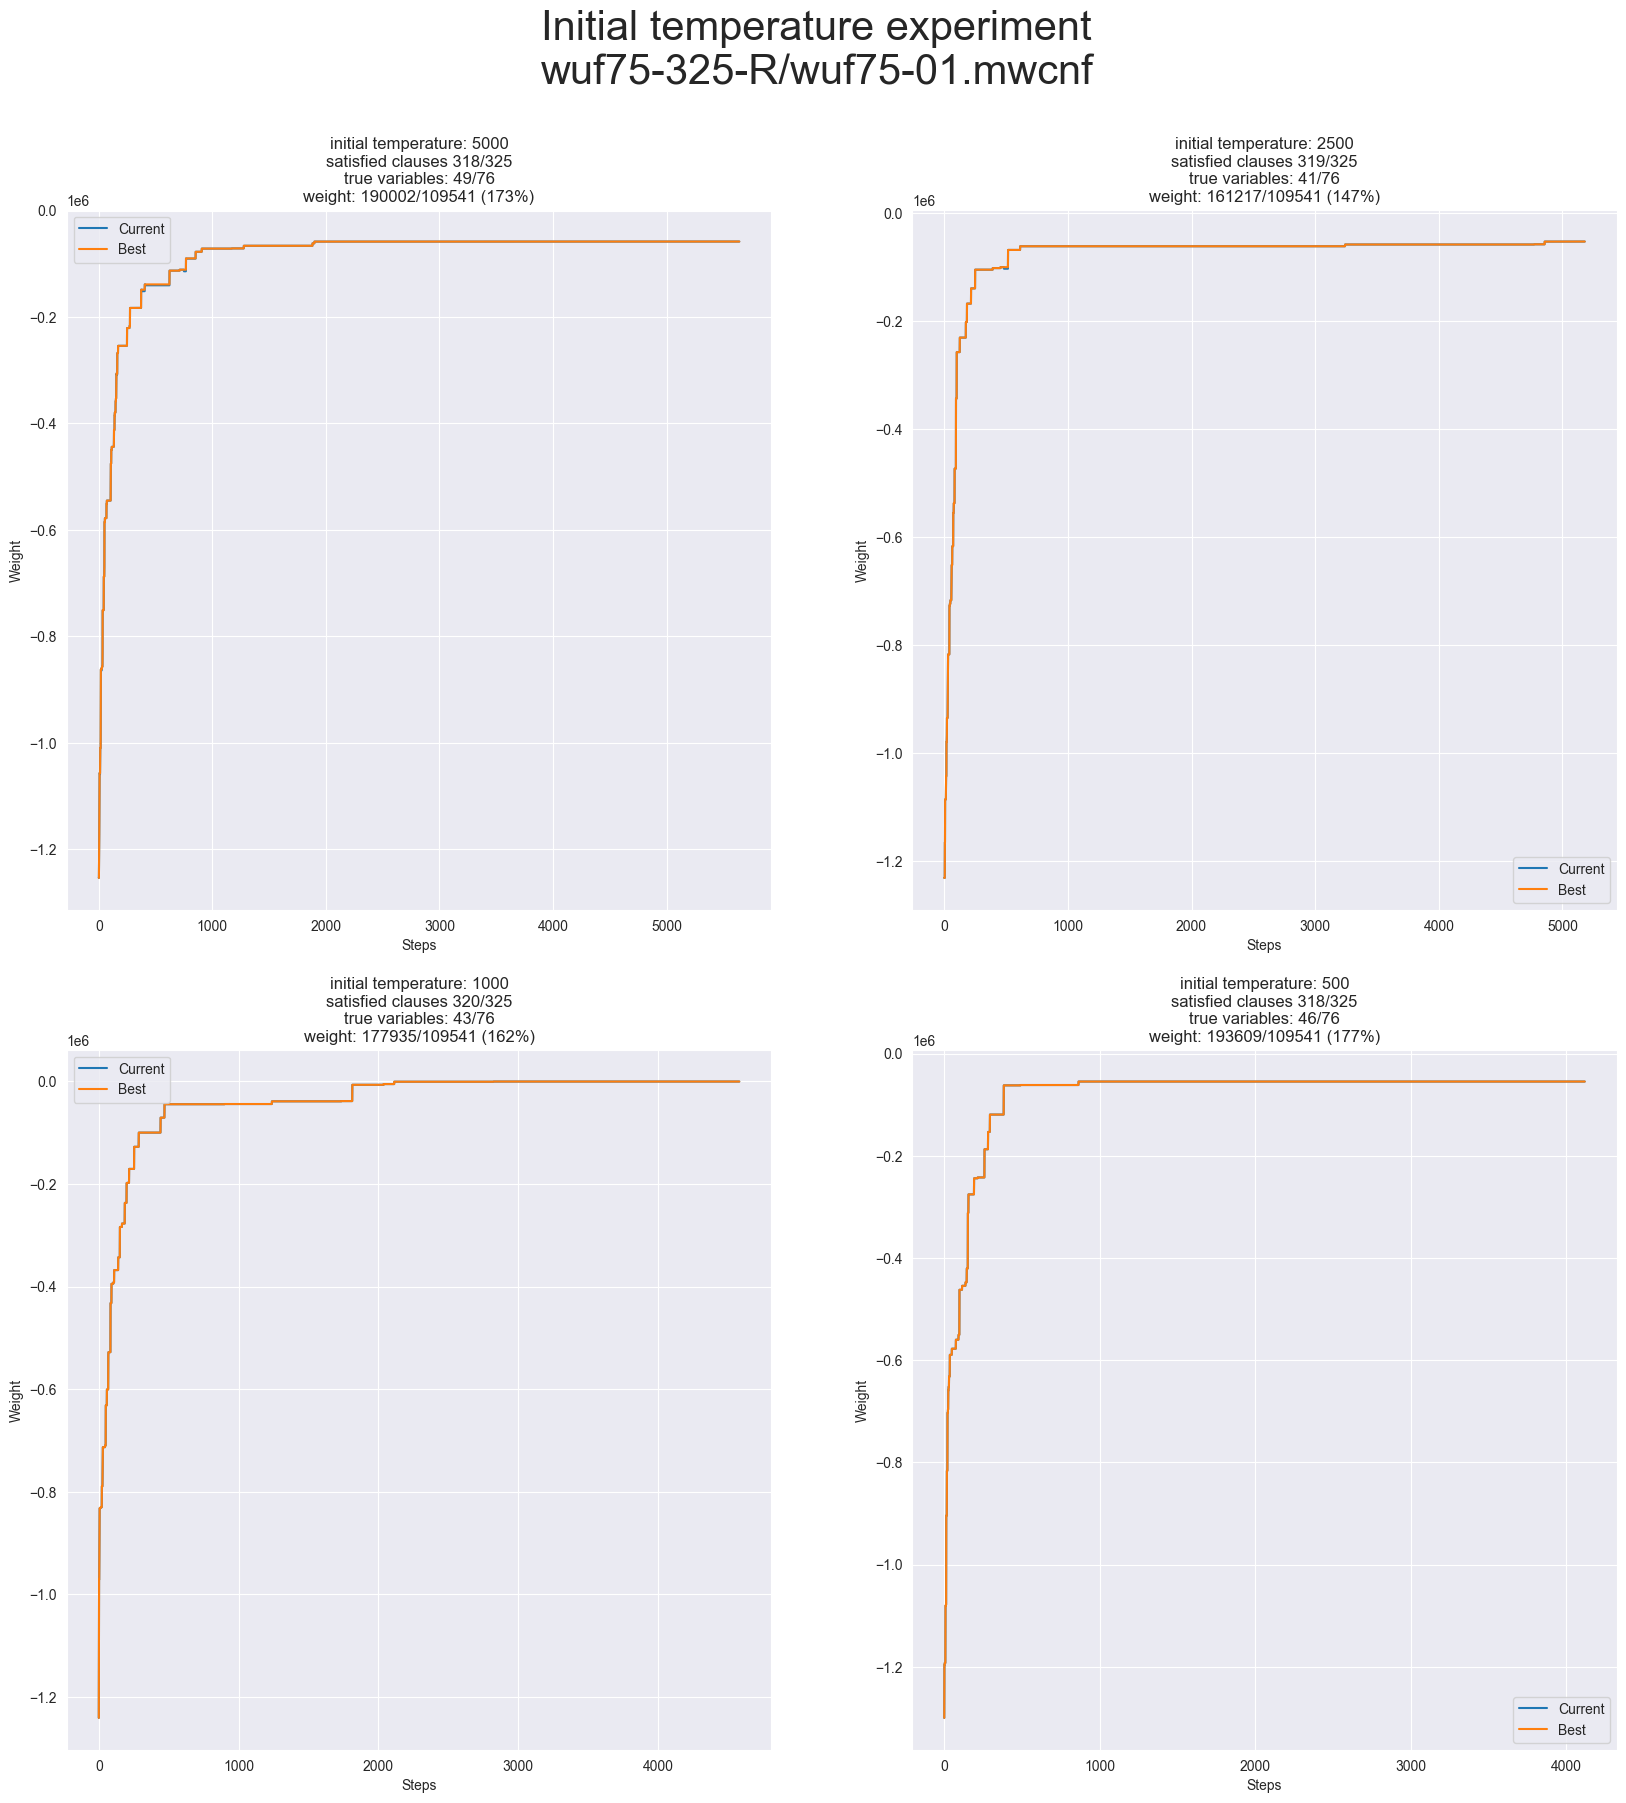

In [11]:
suite = 'wuf75-325'
suite_variation = 'R'
instance = 'wuf75-01.mwcnf'

run_experiment_initial_temperature(suite, suite_variation, instance)

In [12]:
# suite = 'wuf75-325'
# suite_variation = 'R'
# instance = 'wuf75-01.mwcnf'
#
# run_experiment_initial_temperature(suite, suite_variation, instance)

In [52]:
def run_batch(suite, suite_variation, initial_temperature, runs=1):
    print(suite, suite_variation, initial_temperature)

    for root, _, files in os.walk(os.path.join(DATA_DIRECTORY, suite, f'{suite}-{suite_variation}')):
        sas = flatten([
            [
                SimulatedAnnealing(
                    MaxWeightedCNF(os.path.join(root, file)),
                    initial_temperature=initial_temperature
                )
            ] * runs for file in files
        ])

        pool = multiprocessing.Pool(processes=8)

        return list(tqdm(pool.imap(run_simulated_annealing, sas), total=len(sas)))

In [55]:
def run_initial_temperature_experiemnts():
    experiment = {}

    # for suite in ('wuf20-71R', 'wuf20-91R', 'wuf50-218R', 'wuf75-325'):
    for suite in ('wuf20-71R','wuf50-218R'):
        experiment_suite = []
        for suite_variation in ('M','N','Q','R'):
        # for suite_variation in DATA_SUITES_VARIATIONS:
            for initial_temperature in [6000, 5000, 4000, 3000, 2000, 1000, 500]:
                sa_results = run_batch(suite, suite_variation, initial_temperature)

                optimum_path = os.path.join(DATA_DIRECTORY, suite, f'{suite}-{suite_variation}-opt.dat')
                optimum = Optimum(optimum_path)

                accurate = 0
                for result in sa_results:
                    instance = result[0].split('/')[-1]
                    weight = result[1]

                    optimal_weight = optimum.optimal_weight(instance[1:].rstrip('.mwcnf'))

                    if weight == optimal_weight:
                        accurate += 1

                accuracy = round(100 * (accurate / len(sa_results)), 1)

                experiment_suite.append({
                    'suite': suite,
                    'variation': suite_variation,
                    'initial_temperature': initial_temperature,
                    'accuracy': accuracy,
                })
        experiment[suite] = experiment_suite
    return experiment

In [56]:
experiments = run_initial_temperature_experiemnts()

wuf20-71R M 6000


100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


wuf20-71R M 5000


100%|██████████| 100/100 [00:10<00:00,  9.64it/s]


wuf20-71R M 4000


100%|██████████| 100/100 [00:10<00:00,  9.89it/s]


wuf20-71R M 3000


100%|██████████| 100/100 [00:09<00:00, 10.20it/s]

wuf20-71R M 2000



100%|██████████| 100/100 [00:09<00:00, 10.56it/s]


wuf20-71R M 1000


100%|██████████| 100/100 [00:08<00:00, 11.54it/s]

wuf20-71R M 500



100%|██████████| 100/100 [00:07<00:00, 13.01it/s]

wuf20-71R N 6000



100%|██████████| 100/100 [00:10<00:00,  9.48it/s]

wuf20-71R N 5000



100%|██████████| 100/100 [00:10<00:00,  9.56it/s]


wuf20-71R N 4000


100%|██████████| 100/100 [00:10<00:00,  9.87it/s]

wuf20-71R N 3000



100%|██████████| 100/100 [00:09<00:00, 10.16it/s]

wuf20-71R N 2000



100%|██████████| 100/100 [00:09<00:00, 10.87it/s]

wuf20-71R N 1000



100%|██████████| 100/100 [00:08<00:00, 11.74it/s]


wuf20-71R N 500


100%|██████████| 100/100 [00:07<00:00, 13.10it/s]

wuf20-71R Q 6000



100%|██████████| 100/100 [00:10<00:00,  9.47it/s]


wuf20-71R Q 5000


100%|██████████| 100/100 [00:10<00:00,  9.16it/s]

wuf20-71R Q 4000



100%|██████████| 100/100 [00:10<00:00,  9.85it/s]

wuf20-71R Q 3000



100%|██████████| 100/100 [00:09<00:00, 10.17it/s]

wuf20-71R Q 2000



100%|██████████| 100/100 [00:09<00:00, 10.81it/s]


wuf20-71R Q 1000


100%|██████████| 100/100 [00:08<00:00, 11.70it/s]

wuf20-71R Q 500



100%|██████████| 100/100 [00:07<00:00, 13.02it/s]


wuf20-71R R 6000


100%|██████████| 100/100 [00:10<00:00,  9.41it/s]

wuf20-71R R 5000



100%|██████████| 100/100 [00:10<00:00,  9.62it/s]

wuf20-71R R 4000



100%|██████████| 100/100 [00:10<00:00,  9.86it/s]

wuf20-71R R 3000



100%|██████████| 100/100 [00:09<00:00, 10.20it/s]

wuf20-71R R 2000



100%|██████████| 100/100 [00:09<00:00, 10.79it/s]


wuf20-71R R 1000


100%|██████████| 100/100 [00:08<00:00, 11.95it/s]

wuf20-71R R 500



100%|██████████| 100/100 [00:07<00:00, 13.15it/s]


wuf50-218R M 6000


100%|██████████| 100/100 [00:30<00:00,  3.28it/s]

wuf50-218R M 5000



100%|██████████| 100/100 [00:29<00:00,  3.35it/s]


wuf50-218R M 4000


100%|██████████| 100/100 [00:29<00:00,  3.45it/s]

wuf50-218R M 3000



100%|██████████| 100/100 [00:28<00:00,  3.54it/s]

wuf50-218R M 2000



100%|██████████| 100/100 [00:27<00:00,  3.61it/s]


wuf50-218R M 1000


100%|██████████| 100/100 [00:24<00:00,  4.05it/s]

wuf50-218R M 500



100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


wuf50-218R N 6000


100%|██████████| 100/100 [00:30<00:00,  3.25it/s]

wuf50-218R N 5000



100%|██████████| 100/100 [00:29<00:00,  3.34it/s]


wuf50-218R N 4000


100%|██████████| 100/100 [00:29<00:00,  3.40it/s]


wuf50-218R N 3000


100%|██████████| 100/100 [00:34<00:00,  2.88it/s]


wuf50-218R N 2000


100%|██████████| 100/100 [00:35<00:00,  2.82it/s]


wuf50-218R N 1000


100%|██████████| 100/100 [00:24<00:00,  4.00it/s]


wuf50-218R N 500


100%|██████████| 100/100 [00:25<00:00,  3.85it/s]


wuf50-218R Q 6000


100%|██████████| 100/100 [00:33<00:00,  3.00it/s]

wuf50-218R Q 5000



100%|██████████| 100/100 [00:31<00:00,  3.13it/s]

wuf50-218R Q 4000



100%|██████████| 100/100 [00:38<00:00,  2.62it/s]


wuf50-218R Q 3000


100%|██████████| 100/100 [00:34<00:00,  2.88it/s]


wuf50-218R Q 2000


100%|██████████| 100/100 [00:37<00:00,  2.65it/s]


wuf50-218R Q 1000


100%|██████████| 100/100 [00:24<00:00,  4.02it/s]

wuf50-218R Q 500



100%|██████████| 100/100 [00:22<00:00,  4.43it/s]


wuf50-218R R 6000


100%|██████████| 100/100 [00:32<00:00,  3.08it/s]


wuf50-218R R 5000


100%|██████████| 100/100 [00:31<00:00,  3.13it/s]

wuf50-218R R 4000



100%|██████████| 100/100 [00:31<00:00,  3.20it/s]


wuf50-218R R 3000


100%|██████████| 100/100 [00:29<00:00,  3.37it/s]

wuf50-218R R 2000



100%|██████████| 100/100 [00:25<00:00,  3.91it/s]

wuf50-218R R 1000



100%|██████████| 100/100 [00:26<00:00,  3.75it/s]


wuf50-218R R 500


100%|██████████| 100/100 [00:24<00:00,  4.05it/s]


In [58]:
for experiment in experiments:
    print(experiments[experiment])

[{'suite': 'wuf20-71R', 'variation': 'M', 'initial_temperature': 6000, 'accuracy': 99.0}, {'suite': 'wuf20-71R', 'variation': 'M', 'initial_temperature': 5000, 'accuracy': 99.0}, {'suite': 'wuf20-71R', 'variation': 'M', 'initial_temperature': 4000, 'accuracy': 100.0}, {'suite': 'wuf20-71R', 'variation': 'M', 'initial_temperature': 3000, 'accuracy': 100.0}, {'suite': 'wuf20-71R', 'variation': 'M', 'initial_temperature': 2000, 'accuracy': 99.0}, {'suite': 'wuf20-71R', 'variation': 'M', 'initial_temperature': 1000, 'accuracy': 99.0}, {'suite': 'wuf20-71R', 'variation': 'M', 'initial_temperature': 500, 'accuracy': 99.0}, {'suite': 'wuf20-71R', 'variation': 'N', 'initial_temperature': 6000, 'accuracy': 99.0}, {'suite': 'wuf20-71R', 'variation': 'N', 'initial_temperature': 5000, 'accuracy': 97.0}, {'suite': 'wuf20-71R', 'variation': 'N', 'initial_temperature': 4000, 'accuracy': 97.0}, {'suite': 'wuf20-71R', 'variation': 'N', 'initial_temperature': 3000, 'accuracy': 98.0}, {'suite': 'wuf20-71

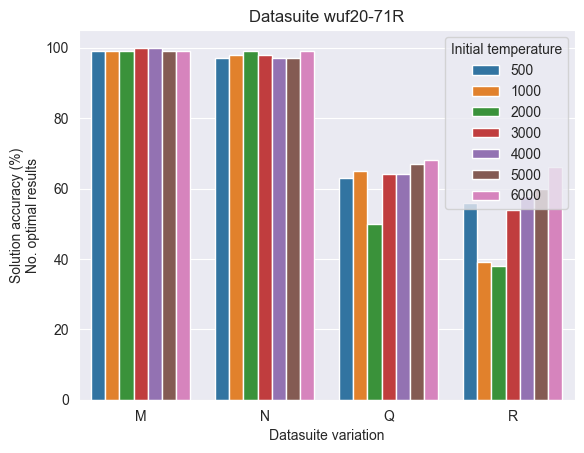

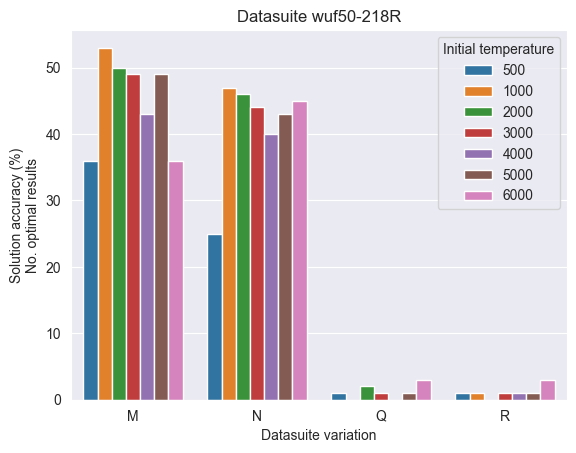

In [66]:
for experiment in experiments:
    df = pd.DataFrame.from_records(experiments[experiment])
    df['Initial temperature'] = df['initial_temperature']
    ax = sns.barplot(data=df,
                     x='variation', y='accuracy',
                     hue='Initial temperature',
                     errorbar=None)
    ax.set_title(f'Datasuite {experiment}')
    ax.set_xlabel('Datasuite variation')
    ax.set_ylabel(f'Solution accuracy (%)\nNo. optimal results')
    plt.show()